In [18]:
%matplotlib inline
import os
import json
from collections import defaultdict
import operator
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [31]:
n_tags = 100

In [32]:
tags = defaultdict(int)
with open("lastfm_unique_tags.txt") as tagfile:
    for x in range(n_tags):
        tag = tagfile.readline().split("\t")
        tags[tag[0]] = int(tag[1][0:-1])

In [33]:
sorted_tags = sorted(tags.items(), key=operator.itemgetter(1), reverse=True)

In [34]:
indexed_tags = [(t[1][0], t[0]) for t in enumerate(sorted_tags[:n_tags])]

In [36]:
song_vector = defaultdict(int)
for root, subdirs, files in os.walk("data/lastfm_test/"):
    for file in files:
        with open(os.path.join(root, file)) as file_data:
            file_data = json.load(file_data)
            vector = []
            file_tags = dict(file_data['tags'])
            for tag in indexed_tags:
                if tag[0] in file_tags:
                    vector.append(int(file_tags[tag[0]]))
                else:
                    vector.append(0)
            song_vector[file_data['track_id']] = vector

In [37]:
model = make_pipeline(KMeans(n_clusters=100), Normalizer(), PCA(n_components=2))
model.fit(list(song_vector.values()))

#model = PCA(n_components=2)
#model.fit(list(song_vector.values()))

#model = km(n_clusters=2)
#model.fit(list(song_vector.values()))


Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)), ('normalizer', Normalizer(copy=True, norm='l2')), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

In [159]:
#model.explained_variance_ratio_

In [38]:
component = {}
for title,pc in song_vector.items():
    component[title] = model.transform([pc]).flatten()


In [39]:
import pandas as pd

In [40]:
df = pd.DataFrame(component).transpose()

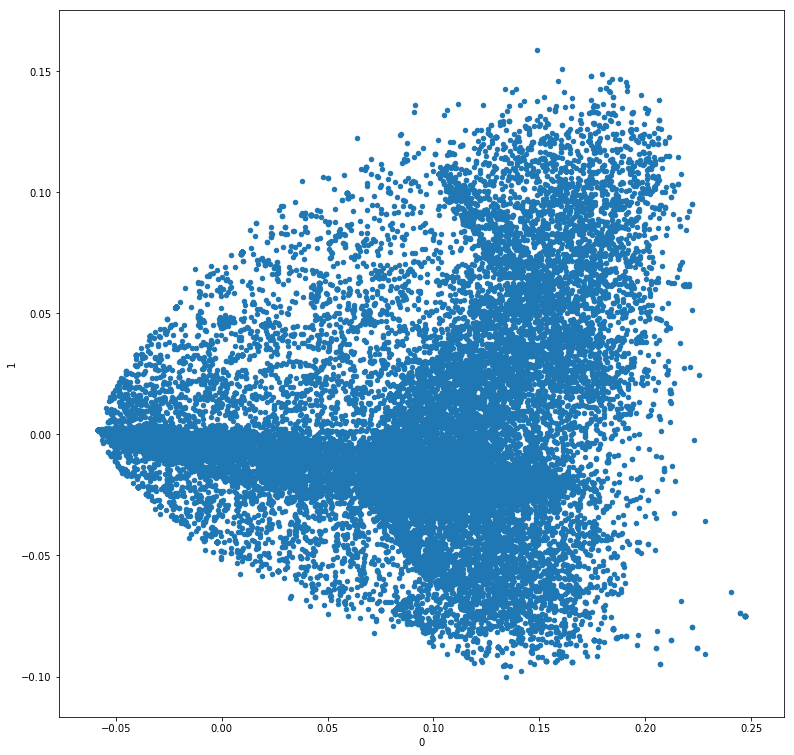

In [42]:
df.plot.scatter(x=0, y=1, figsize=(13, 13))

In [43]:
genres = {}
for tag in indexed_tags:
    genres[tag[0]] = [100 if x == tag[1] else 0 for x in range(n_tags)]

In [44]:
genres_pc = {k: model.transform([v]) for k, v in genres.items()}

In [93]:
with open("tags.json", "w") as tagfile:
    tags_object = []
    for tag in indexed_tags:
        name = tag[0]
        tags_object.append({"name": name, "x": genres_pc[name][0][0], "y": genres_pc[name][0][1], "n": tags[name]})
    json.dump(tags_object, tagfile)

In [89]:
#with open("songs.json", "w") as songfile:
    #d = [{'name': k, 'x': v.c[0], 'y' :v[1]} for k,v in component.items()]
    #json.dump(d, songfile)